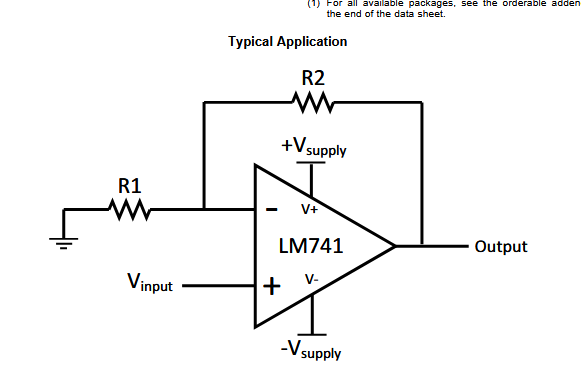 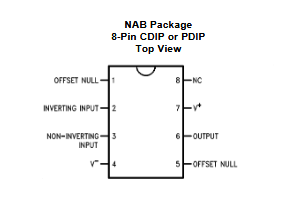 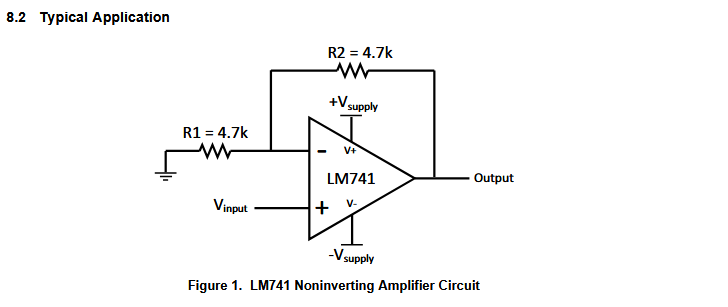

# etat donné que j'ai R1= R2 on aura A = 2 car j'utilise un circuit non-inverseur

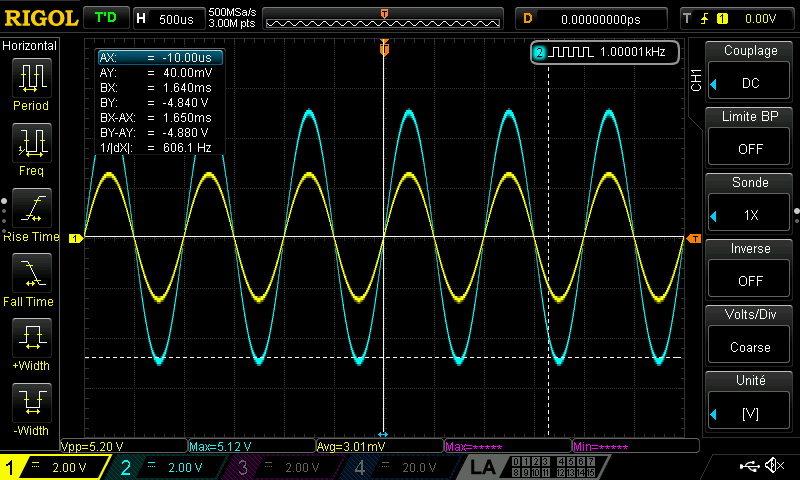

In [2]:
import pyvisa

rm = pyvisa.ResourceManager()       # sans '@py' car on uutlise NI-VISA
ID=rm.list_resources()
print("generateur:",ID)

generateur: ('USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')


In [3]:
import pyvisa

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
print("Ressources trouvées :", resources)

generator_addr = None
scope_addr = None

for addr in resources:
    # On classe juste avec le texte de l'adresse
    if "DG1D" in addr or "DG" in addr:
        generator_addr = addr
    elif "DS1Z" in addr or "DS" in addr:
        scope_addr = addr

print("Générateur :", generator_addr)
print("Oscilloscope :", scope_addr)

# Maintenant on ouvre vraiment les deux
generator = rm.open_resource(generator_addr)
scope = rm.open_resource(scope_addr)

generator.timeout = 3000
generator.read_termination = '\n'
generator.write_termination = '\n'

scope.timeout = 3000
scope.read_termination = '\n'
scope.write_termination = '\n'

# # Optionnel : on essaie *IDN? séparément, avec try/except
# try:
#     print("IDN générateur :", generator.query("*IDN?").strip())
# except Exception as e:
#     print("Impossible de lire *IDN? du générateur :", e)

# try:
#     print("IDN oscillo :", scope.query("*IDN?").strip())
# except Exception as e:
#     print("Impossible de lire *IDN? de l'oscillo :", e)


Ressources trouvées : ('USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
Générateur : USB0::0x0400::0x09C4::DG1F143800623::INSTR
Oscilloscope : None


VisaIOError: VI_ERROR_INV_RSRC_NAME (-1073807342): Invalid resource reference specified. Parsing error.

# Generer un signal sinus et mesure de VPP 

In [5]:
import time

#  Config du générateur : sinus 10 kHz, 0.5 Vpp, offset 0 V
generator.write("VOLT:UNIT VPP")             # amplitude en Vpp
generator.write("APPL:SIN 1000,0.5,0")       # f=10000 Hz, A=0.5 Vpp, offset=0
generator.write("OUTP1 ON")                  # sortie CH1
generator.write("OUTP2 OFF")                 # sortie CH2 off

time.sleep(0.3)  # attente de stabilisation

#  Config de la mesure sur l'oscillo
scope.write(":MEASure:SOURce CHAN1")     
   

#  Lecture des mesures de base
vmax = float(scope.query(":MEASure:VMAX?"))
vmin = float(scope.query(":MEASure:VMIN?"))
vpp  = float(scope.query(":MEASure:VPP?"))
freq = float(scope.query(":MEASure:FREQuency?"))

print(f"Vmax = {vmax:.3f} V")
print(f"Vmin = {vmin:.3f} V")
print(f"Vpp  = {vpp:.3f} V")
print(f"f    = {freq:.2f} Hz")


NameError: name 'scope' is not defined

In [1]:
# Liste d'amplitudes à tester (Vpp)
amplitudes_test = [0.1, 0.2, 0.5, 1.0, 2.0]
mesures_vpp = []

for A in amplitudes_test:
    generator.write(f"APPL:SIN 1000,{A},0")
    generator.write("OUTP1 ON")
    time.sleep(5)

    vpp = float(scope.query(":MEASure:VPP?"))
    mesures_vpp.append(vpp)

    print(f"Amplitude entrée = {A:.2f} Vpp → Vpp mesurée = {vpp:.3f} Vpp")


NameError: name 'generator' is not defined

# courbe 

In [13]:
import matplotlib.pyplot as plt

plt.plot(amplitudes_test, mesures_vpp, 'o-')
plt.xlabel("Amplitude entrée (Vpp)")
plt.ylabel("Amplitude mesurée (Vpp)")
plt.title("Réponse amplitude du montage (LM741)")
plt.grid(True)
plt.show()


NameError: name 'amplitudes_test' is not defined

# mesure de Vin

In [14]:
scope.write(":MEASure:SOURce CHAN1")
vpp_in = float(scope.query(":MEASure:VPP?"))
print(f"Amplitude d'entrée = {vpp_in:.3f} Vpp")

Amplitude d'entrée = 0.600 Vpp


# mesure de Vout

In [18]:
scope.write(":MEASure:SOURce CHAN2")
vpp_out = float(scope.query(":MEASure:VPP?"))
print(f"Amplitude de sortie = {vpp_out:.3f} Vpp")

Amplitude de sortie = 98999999999999993426744560981400092672.000 Vpp


# balayage en fréquence et courbe de gain 

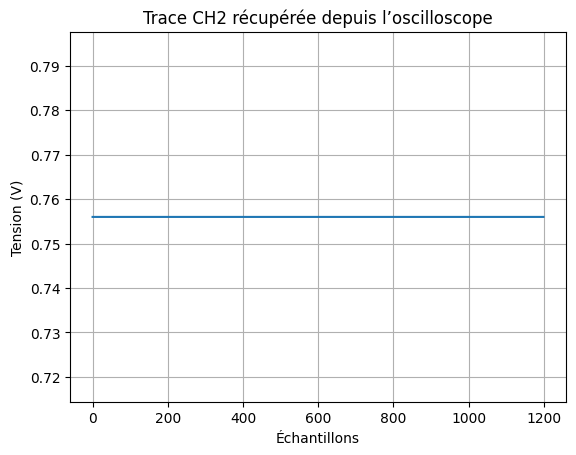

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Sélection de la source
scope.write(":WAV:FORM ASCii")
scope.write(":WAV:SOUR CHAN2")
scope.write(":WAV:MODE NORMal")

# Lecture brute
raw = scope.query(":WAV:DATA?")

# --- Correction : retirer le header #9xxxxxx ---
# Exemple : "#90000155996.599988e+00, ..."
if raw.startswith('#'):
    header_length = int(raw[1])                # ex: '9'
    num_chars = int(raw[2:2+header_length])    # ex: '000015599'
    data_start = 2 + header_length
    raw_data = raw[data_start:]                # uniquement les valeurs
else:
    raw_data = raw

# Convertir en tableau numérique
values = np.array([float(v) for v in raw_data.split(',') if v.strip() != ""])

# Axe temps fictif
t = np.arange(len(values))

plt.figure()
plt.plot(t, values)
plt.xlabel("Échantillons")
plt.ylabel("Tension (V)")
plt.title("Trace CH2 récupérée depuis l’oscilloscope")
plt.grid(True)
plt.show()


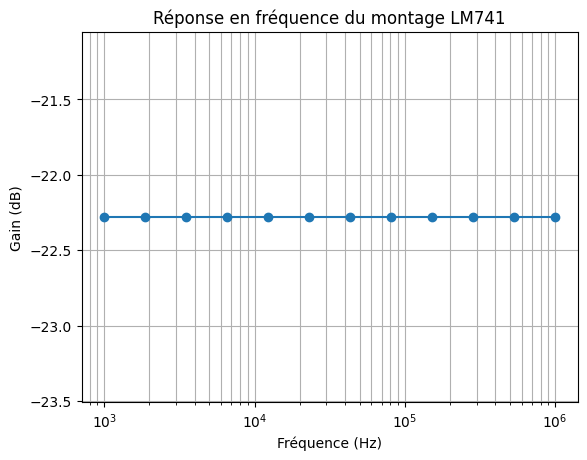

In [72]:
plt.figure()
plt.semilogx(frequencies, gain_db, marker="o")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Gain (dB)")
plt.title("Réponse en fréquence du montage LM741")
plt.grid(True, which="both")
plt.show()


In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Choisir la source : CHAN2 (par exemple la sortie du LM741)
scope.write(":WAVeform:SOURce CHAN2")
scope.write(":WAVeform:FORMat ASCii")
scope.write(":WAVeform:MODE NORMal")  # ou RAW suivant le scope

# On peut limiter le nombre de points (facultatif)
# scope.write(":WAVeform:STARt 1")
# scope.write(":WAVeform:STOP  1200")

# Récupérer les données
raw = scope.query(":WAVeform:DATA?")

# La réponse est typiquement du type "0.0123,0.0456,..."
# On convertit en tableau de float
values = np.array([float(v) for v in raw.split(',') if v.strip() != ""])

# Axe temps simplifié : un échantillon = 1 unité arbitraire
t = np.arange(len(values))

plt.figure()
plt.plot(t, values)
plt.xlabel("Échantillons (index)")
plt.ylabel("Tension (V) ~")
plt.title("Forme d'onde récupérée depuis l'oscilloscope")
plt.grid(True)
plt.show()


ValueError: could not convert string to float: '#90000155996.999987e+00'